# Jupyter Note - Neural Style Transfer

**Author : Hon Wai Ting**

# Import packages & Create directories

In [100]:
import sys
import os

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision

import accelerate
from accelerate import Accelerator

# dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accelerator = Accelerator()
dvc = accelerator.device

# Print Device and Library Version
print(f"Using device: {dvc}")
print(f"Python version={sys.version}")
print(f"torch version={torch.__version__}")
print(f"torchvision version={torchvision.__version__}")
print(f"accelerate version={accelerate.__version__}")
print(f"matplotlib version={matplotlib.__version__}")

# Create Directory
INPUT_PATH="./inputs"
OUTPUT_PATH="./outputs"
os.makedirs(INPUT_PATH, exist_ok=True) # Input Directory
os.makedirs(OUTPUT_PATH, exist_ok=True) # Output Directory

Using device: cpu
Python version=3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:50:49) [Clang 16.0.6 ]
torch version=2.5.1
torchvision version=0.20.1
accelerate version=1.10.1
matplotlib version=3.10.0


# Google Drive Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Change the current working directory
import os;
os.chdir("/content/drive/MyDrive/Colab/Neural Style Transfer")
print(os.getcwd())

# Define the model aritechture for our task

## Import Pretrained model VGG19

In [101]:
vgg16_model = torchvision.models.vgg16(weights=torchvision.models.vgg.VGG16_Weights.DEFAULT)
print(vgg16_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/specter/.cache/torch/hub/checkpoints/vgg16-397923af.pth
 15%|█▍        | 78.1M/528M [00:17<01:42, 4.60MB/s]


KeyboardInterrupt: 

In [116]:
vgg19_model = torchvision.models.vgg19(weights=torchvision.models.vgg.VGG19_Weights.DEFAULT)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Build Our Own Architecture

In [117]:
class NSTNetwork(nn.Module):
    def __init__(
        self,
        feature_extractor : nn.Module,
        selected_style_layernames : list[str],
        selected_content_layernames : list[str],
        use_avgpool : bool = False
    ):
        super().__init__()

        # Get Indices
        self.style_loss_indices = [int(name.split("_")[1]) - 1 for name in selected_style_layernames]
        self.content_loss_indices = [int(name.split("_")[1]) - 1 for name in selected_content_layernames]

        # Define Normalisation Function
        self.normalise = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        slices : list[nn.Sequencial] = []
        slice = nn.Sequential()

        i = 0;
        for layer in feature_extractor.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
                layer = nn.AvgPool2d(layer.kernel_size, layer.stride, layer.padding) if use_avgpool else layer
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            slice.add_module(name, layer)
            if name in selected_style_layernames:
                slices.append(slice)
                slice = nn.Sequential()

            if name == max(selected_style_layernames):
                break

        self.extractor = nn.Sequential()
        for i, slice in enumerate(slices,1):
            self.extractor.add_module(f"slice_{i}", slice)

    def forward(self, x) -> list[torch.Tensor]:
        x = self.normalise(x)
        feature_maps : list[torch.Tensor] = []
        for slice in self.extractor.children():
            x = slice(x)
            feature_maps.append(x)
        return feature_maps



# Inference

## Import our model from local directory

In [118]:
style_layernames=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
content_layernames=['conv_4']

# Define Our Model
net = NSTNetwork(
    feature_extractor=vgg19_model.features,
    selected_style_layernames=style_layernames,
    selected_content_layernames=content_layernames,
    use_avgpool=True
)

# Disable Gradient and Turn Model to Evaluation Model
net.requires_grad_(False)
net.eval()
net.to(dvc)
net = accelerator.prepare(net)

In [119]:
print(net)

NSTNetwork(
  (normalise): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (extractor): Sequential(
    (slice_1): Sequential(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (slice_2): Sequential(
      (relu_1): ReLU()
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (slice_3): Sequential(
      (relu_2): ReLU()
      (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (slice_4): Sequential(
      (relu_3): ReLU()
      (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (slice_5): Sequential(
      (relu_4): ReLU()
      (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)


## Import Content and Style Images

Original image size: (1264, 1264)
New image size: (1264, 1264)
Original image size: (524, 502)
New image size: (502, 502)
style_image.shape: torch.Size([1, 3, 128, 128])
content_image.shape: torch.Size([1, 3, 128, 128])


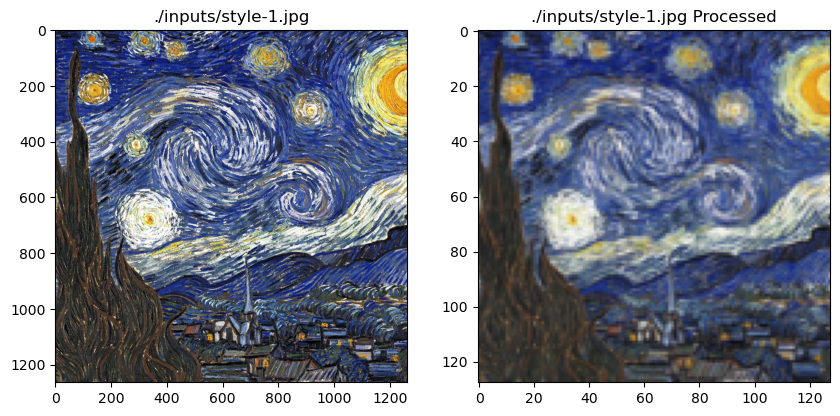

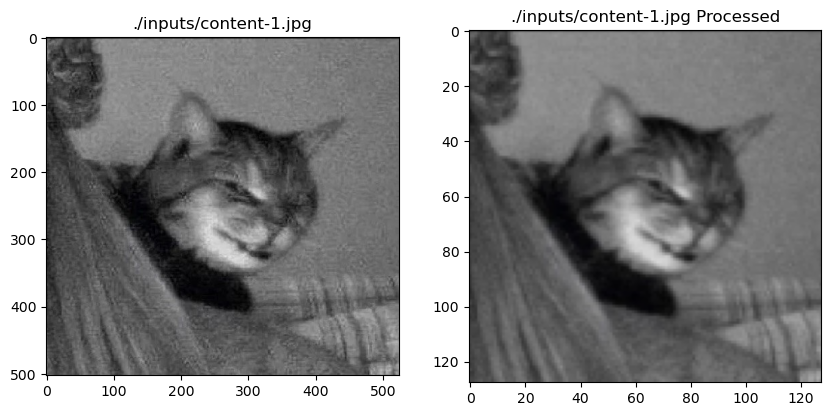

In [120]:
BIG_DIM=512
SMALL_DIM=128
image_dimension = BIG_DIM if torch.cuda.is_available() else SMALL_DIM

def image_to_tensor(image_filepath : str, image_dimension : int =SMALL_DIM) -> torch.Tensor:
    img = Image.open(image_filepath).convert('RGB')

    print(f"Original image size: {img.size}")

    # display image to check
    fig, axs = plt.subplots(1,2, figsize=(10, 6))
    axs[0].set_title(f"{image_filepath}")
    axs[0].imshow(img)

    # Central-crop the image if it is not square
    if img.height != img.width:
        width, height = img.size
        min_dim = min(width, height)
        left = (width - min_dim) / 2
        top = (height - min_dim) / 2
        right = (width + min_dim) / 2
        bottom = (height + min_dim) / 2
        box = (left, top, right, bottom)
        img = img.crop(box)

    # Scale-up image if it is too small
    if img.height < image_dimension or img.width < image_dimension:
      scaling_factor = image_dimension / max(img.size)

      new_width = int(img.width * scaling_factor)
      new_height = int(img.height * scaling_factor)

      img = img.resize((new_width, new_height), Image.LANCZOS)

    print(f"New image size: {img.size}")

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_dimension),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)

    # Display Processed Image, Sub plt
    axs[1].set_title(f"{image_filepath} Processed")
    axs[1].imshow(img.squeeze(0).cpu().detach().numpy().transpose(1,2,0))

    return img.to(torch.float)

style_image = image_to_tensor(f"{INPUT_PATH}/style-1.jpg", image_dimension).to(dvc).detach()
content_image = image_to_tensor(f"{INPUT_PATH}/content-1.jpg", image_dimension).to(dvc).detach()
print(f"style_image.shape: {style_image.shape}")
print(f"content_image.shape: {content_image.shape}")

## Define input tensor

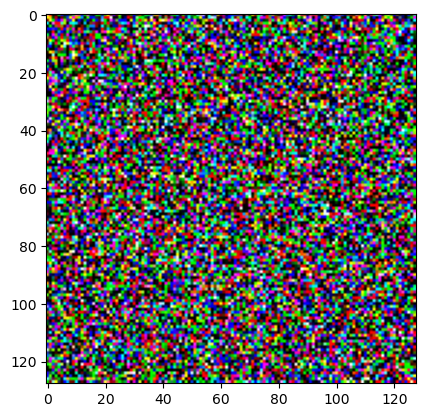

In [121]:
# initialize as the content image
# ip_image = content_image.clone().to(dvc)

# initialize as random noise:
ip_image = torch.randn(content_image.data.size(), device=dvc)

plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

## Inference Pipeline

### Define Functions and Variables before inference

In [110]:
# Define gram matrix
def gram_matrix(ip : torch.Tensor) -> torch.Tensor:
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch * num_channels * width * height)

### Do it

In [ ]:
%%time
num_epochs= 2000
loss_checkpoint_step = 50
image_checkpoint_step = 200

epoch_style_losses = []
epoch_content_losses = []

ip_image = Variable(ip_image, requires_grad=True)

wt_style=1e6
wt_content=1

opt = optim.LBFGS([ip_image], lr=1)
opt = accelerator.prepare(opt)

for curr_epoch in range(1, num_epochs+1):
    ip_image.data.clamp_(0, 1)
    opt.zero_grad()

    epoch_style_loss = 0
    epoch_content_loss = 0
    epoch_pixel_loss = 0

    x = ip_image
    yc = content_image.detach()
    ys = style_image.detach()

    feature_maps_x = net(x)
    feature_maps_yc = net(yc)
    feature_maps_ys = net(ys)

    for i,(f_x,f_yc,f_ys) in enumerate(zip(feature_maps_x,feature_maps_yc,feature_maps_ys)):
        if i in net.style_loss_indices:
            epoch_style_loss += F.mse_loss(gram_matrix(f_x), gram_matrix(f_ys.detach()).detach())
        if i in net.content_loss_indices:
            epoch_content_loss += F.mse_loss(f_x, f_yc.detach())

    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content

    total_loss = epoch_style_loss + epoch_content_loss
    accelerator.backward(total_loss)

    def closure() -> torch.Tensor:
        return total_loss

    if curr_epoch % loss_checkpoint_step == 0:
        epoch_style_losses += [epoch_style_loss.cpu().detach().numpy()]
        epoch_content_losses += [epoch_content_loss.cpu().detach().numpy()]
        epoch_pixel_losses += [epoch_pixel_loss.cpu().detach().numpy()]
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")

    if curr_epoch % image_checkpoint_step == 0:
        display_image = ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach()
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(display_image.numpy().transpose(1,2,0))
        plt.show()
        torchvision.utils.save_image(
            display_image,
            f"{OUTPUT_PATH}/image_{curr_epoch}.jpg"
        )

    opt.step(closure=closure)

AttributeError: 'int' object has no attribute 'cpu'

## Plot Loss Curve

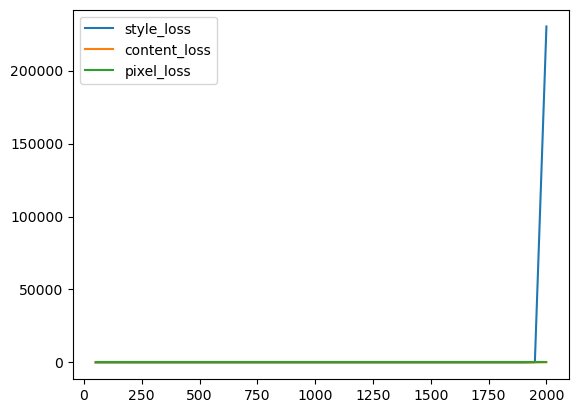

In [ ]:
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_style_losses, label='style_loss');
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_content_losses, label='content_loss');
plt.legend();

# Foundings
- Gradient Explode

ToDos:
- Make it deployable

